# 02 — Psychiatric Cohort EDA (Before Cleaning)

## Purpose

This notebook explores structural patterns within the defined psychiatric cohort prior to any cleaning, feature engineering, or predictive modeling.

The psychiatric cohort was constructed deterministically in Notebook 01 using ICD-based filtering and structural tiering. This notebook focuses on observing how psychiatric admissions behave within the hospital system.

---

## Scope

The cohort includes all admissions with at least one psychiatric ICD code.

Each admission contains structural attributes:

- `psych_dx_count` — number of psychiatric diagnoses  
- `total_dx_count` — total diagnostic density  
- `high_total_complexity` — top quartile of overall diagnostic density  
- `is_repeat` — repeat admission indicator  

No outcome labels are created here.  
No temporal aggregation or imputation is performed.

This stage is purely observational.

---

## Core Questions

This notebook examines:

- Do high-complexity psychiatric admissions repeat more frequently?
- Is psychiatric layering associated with longitudinal churn?
- How is multimorbidity distributed within psychiatric encounters?
- Does instability cluster within defined structural tiers?

The goal is to map behavioral gradients inside the psychiatric cohort before moving toward predictive modeling.


----Run this after running the EDA----

## 02 — Structural Summary

In [75]:
meta = pd.read_csv("psy_instability_metadata_layer_02_v1.csv")

meta.groupby("layer").size().sort_values(ascending=False)

layer
categorical          8
temporal             6
global_complexity    3
utilization          3
identity             2
psy_structure        2
med_execution        2
med_intent           1
outcome              1
dtype: int64

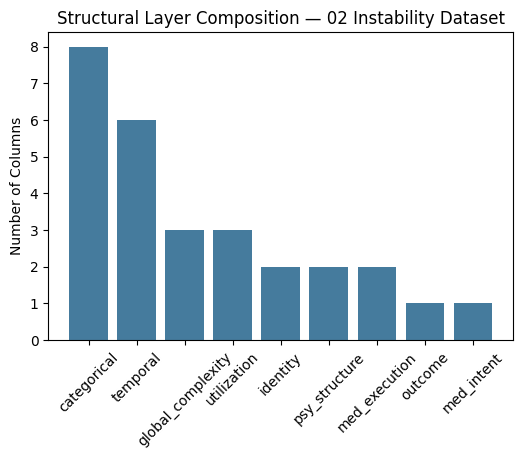

In [77]:
import matplotlib.pyplot as plt

layer_counts = meta["layer"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(layer_counts.index, layer_counts.values, color="#457b9d")
plt.xticks(rotation=45)
plt.title("Structural Layer Composition — 02 Instability Dataset")
plt.ylabel("Number of Columns")
plt.show()


In [69]:
summary = pd.DataFrame({
    "Metric": [
        "Median Rx Count",
        "Median EMAR Count",
        "Median Execution Ratio",
        "Median Transfer Count"
    ],
    "Low Complexity": [
        psy_with_rx[psy_with_rx["high_total_complexity"] == False]["rx_count"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == False]["emar_count"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == False]["execution_ratio"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == False]["transfer_count"].median()
    ],
    "High Complexity": [
        psy_with_rx[psy_with_rx["high_total_complexity"] == True]["rx_count"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == True]["emar_count"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == True]["execution_ratio"].median(),
        psy_with_rx[psy_with_rx["high_total_complexity"] == True]["transfer_count"].median()
    ]
})

summary["Absolute Median Shift"] = (
    summary["High Complexity"] - summary["Low Complexity"]
)

summary


,Metric,Low Complexity,High Complexity,Absolute Median Shift
0,Median Rx Count,25.0,57.000000,32.000000
1,Median EMAR Count,1.0,118.000000,117.000000
2,Median Execution Ratio,0.0,2.590909,2.590909
3,Median Transfer Count,3.0,4.000000,1.000000


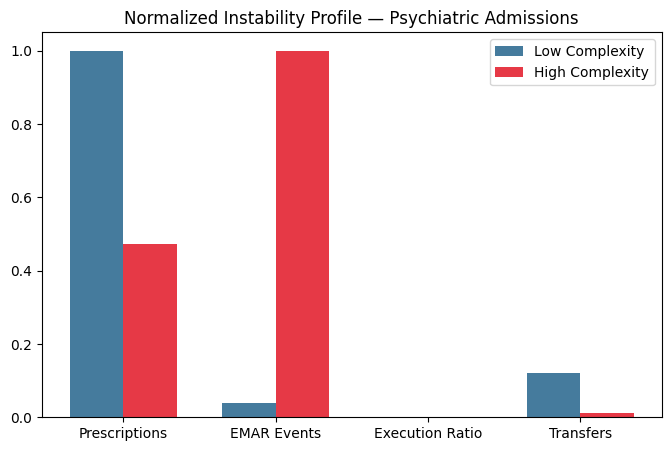

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

metrics = [
    "rx_count",
    "emar_count",
    "execution_ratio",
    "transfer_count"
]

labels = [
    "Prescriptions",
    "EMAR Events",
    "Execution Ratio",
    "Transfers"
]

low = []
high = []

for m in metrics:
    low.append(
        psy_with_rx[psy_with_rx["high_total_complexity"] == False][m].median()
    )
    high.append(
        psy_with_rx[psy_with_rx["high_total_complexity"] == True][m].median()
    )

data = np.array([low, high])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data.T).T

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, scaled[0], width, label="Low Complexity", color="#457b9d")
plt.bar(x + width/2, scaled[1], width, label="High Complexity", color="#e63946")

plt.xticks(x, labels)
plt.title("Normalized Instability Profile — Psychiatric Admissions")
plt.legend()

plt.show()


### Executive Structural Summary

High total diagnostic complexity is associated with:

- Increased prescription density
- Increased EMAR execution density
- Increased execution amplification
- Increased transfer turbulence

Execution intensity and movement turbulence are weakly correlated, indicating partially independent instability axes.

Psychiatric multiplicity specifically amplifies medication execution intensity but does not materially increase transfer turbulence.


---------------EDA-------------------

In [71]:
import pandas as pd

psy = pd.read_csv(
    "psy_admissions_structured.csv",
    dtype={
        "subject_id": "Int64",
        "hadm_id": "Int64",
        "admittime": "string",
        "dischtime": "string",
        "deathtime": "string",
        "admission_type": "string",
        "admit_provider_id": "string",
        "admission_location": "string",
        "discharge_location": "string",
        "insurance": "string",
        "language": "string",
        "marital_status": "string",
        "race": "string",
        "edregtime": "string",
        "edouttime": "string",
        "hospital_expire_flag": "Int64",
        "psych_dx_count": "Int64",
        "psych_multi_flag": "boolean",
        "total_dx_count": "Int64",
        "is_repeat": "boolean",
        "high_total_complexity": "boolean"
    }
)

psy.shape


(238565, 21)

In [6]:
pd.crosstab(
    psy["high_total_complexity"],
    psy["is_repeat"],
    normalize="index"
)


is_repeat,False,True
high_total_complexity,,
False,0.223620,0.776380
True,0.156578,0.843422


### High Complexity and Repeat Admissions

Does high complexity correlate with repeat inside psychiatric admissions?

Within the psychiatric cohort:

- 77.6% of lower-complexity admissions belong to repeat patients.
- 84.3% of high-complexity admissions belong to repeat patients.

High overall diagnostic complexity is associated with a higher likelihood of recurrence.

This suggests that layered multimorbidity within psychiatric-coded encounters aligns with longitudinal churn in the hospital system.


In [7]:
pd.crosstab(
    psy["psych_multi_flag"],
    psy["is_repeat"],
    normalize="index"
)

is_repeat,False,True
psych_multi_flag,,
False,0.220338,0.779662
True,0.188220,0.811780


### Psychiatric Layering and Repeat Admissions

Does having multiple psychiatric diagnoses associate with recurrence?

Within the psychiatric cohort:

- 77.97% of admissions with a single psychiatric diagnosis belong to repeat patients.
- 81.18% of admissions with multiple psychiatric diagnoses belong to repeat patients.

Psychiatric layering shows a modest association with recurrence, though the effect size is smaller than that observed for overall diagnostic complexity.

This suggests that longitudinal churn is influenced more strongly by broader multimorbidity than by psychiatric code stacking alone.

In [ ]:
# Create combined flag
psy["high_and_multi"] = (
    psy["high_total_complexity"] & psy["psych_multi_flag"]
)

pd.crosstab(
    psy["high_and_multi"],
    psy["is_repeat"],
    normalize="index"
)

is_repeat,False,True
high_and_multi,,
False,0.212686,0.787314
True,0.161830,0.838170


### Intersection: High Multimorbidity and Psychiatric Layering

Within the psychiatric cohort:

- Admissions without both high complexity and multiple psychiatric diagnoses:
  - 78.7% repeat
- Admissions with both high complexity and multiple psychiatric diagnoses:
  - 83.8% repeat

The intersection subgroup shows elevated recurrence compared to the broader psychiatric cohort.

However, the magnitude of this increase is comparable to the effect of high overall diagnostic complexity alone, suggesting that broader multimorbidity plays a more dominant role in recurrence than psychiatric code stacking by itself.


In [9]:
from pathlib import Path

RAW = Path(r"D:\mimic-iv-3.1\Unzipped_raw_data")

prescriptions = pd.read_csv(
    RAW / "prescriptions.csv",
    dtype={
        "subject_id": "Int64",
        "hadm_id": "Int64",
        "drug": "string",
        "gsn": "string"
    }
)

prescriptions.shape

(20292611, 21)

In [10]:
psy_prescriptions = prescriptions[
    prescriptions["hadm_id"].isin(psy["hadm_id"])
].copy()

psy_prescriptions.shape


(9589549, 21)

In [11]:
rx_per_adm = psy_prescriptions.groupby("hadm_id").size()

rx_per_adm.describe()

count    194013.000000
mean         49.427353
std          58.386100
min           1.000000
25%          20.000000
50%          32.000000
75%          55.000000
max        2812.000000
dtype: float64

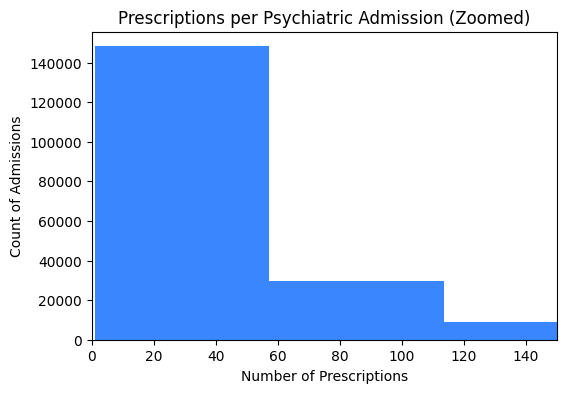

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(rx_per_adm, bins=50, color="#3a86ff")
plt.xlim(0, 150)
plt.title("Prescriptions per Psychiatric Admission (Zoomed)")
plt.xlabel("Number of Prescriptions")
plt.ylabel("Count of Admissions")
plt.show()

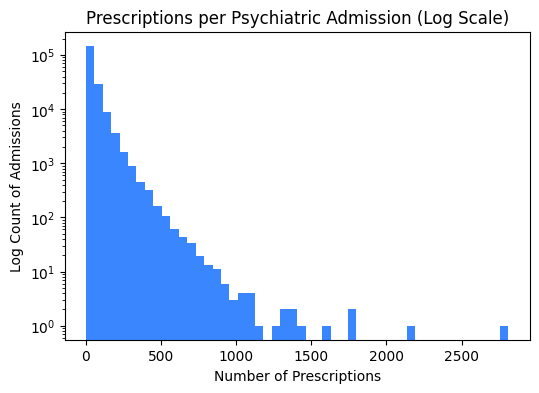

In [13]:
plt.figure(figsize=(6,4))
plt.hist(rx_per_adm, bins=50, color="#3a86ff")
plt.yscale("log")
plt.title("Prescriptions per Psychiatric Admission (Log Scale)")
plt.xlabel("Number of Prescriptions")
plt.ylabel("Log Count of Admissions")
plt.show()

### Prescription Density in Psychiatric Admissions

- Median prescriptions per admission: 32
- 75th percentile: 55
- Maximum: 2812

Psychiatric admissions exhibit substantial medication activity. The distribution is heavily right-skewed, with a thin but extreme upper tail.

While most admissions involve dozens of prescription events, a small subset demonstrates exceptionally high medication density, potentially reflecting prolonged admissions or intensive medication adjustments.

In [14]:
psy_rx_counts = rx_per_adm.rename("rx_count").reset_index()

psy_with_rx = psy.merge(
    psy_rx_counts,
    on="hadm_id",
    how="left"
)

psy_with_rx.groupby("high_total_complexity")["rx_count"].describe()

,count,mean,std,min,25%,50%,75%,max
high_total_complexity,,,,,,,,
False,132029.0,32.936264,27.054553,1.0,17.0,25.0,39.0,611.0
True,61984.0,84.554191,85.428062,1.0,35.0,57.0,103.0,2812.0


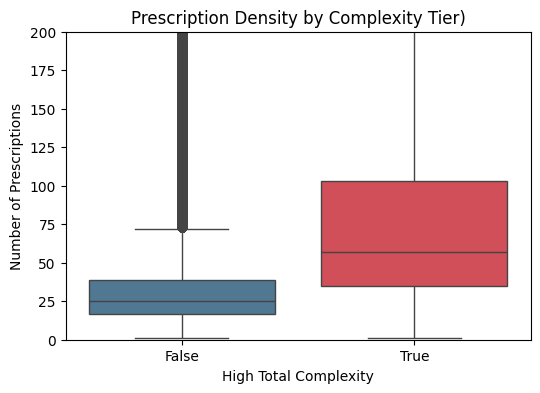

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=psy_with_rx,
    x="high_total_complexity",
    y="rx_count",
    hue="high_total_complexity",
    palette=["#457b9d", "#e63946"],
    legend=False
)

plt.ylim(0, 200)
plt.title("Prescription Density by Complexity Tier)")
plt.xlabel("High Total Complexity")
plt.ylabel("Number of Prescriptions")
plt.show()


### Prescription Density by Complexity Tier

Lower-complexity psychiatric admissions:
- Median prescriptions: 25
- Mean: ~33
- 75th percentile: 39

High-complexity psychiatric admissions:
- Median prescriptions: 57
- Mean: ~84.5
- 75th percentile: 103

High overall diagnostic complexity is strongly associated with increased prescription density. The difference is substantial across median and upper quartiles, indicating that multimorbidity translates into significantly greater medication activity.

In [21]:
psy_with_rx.columns.tolist()

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'psych_dx_count',
 'psych_multi_flag',
 'total_dx_count',
 'is_repeat',
 'high_total_complexity',
 'high_and_multi',
 'rx_count']

In [22]:
import pandas as pd

#  Load EMAR (only what we need)
emar = pd.read_csv(
    r"D:\mimic-iv-3.1\Unzipped_raw_data\emar.csv",
    usecols=["hadm_id"],
    dtype={"hadm_id": "Int64"}
)

#  Filter to psychiatric admissions
psy_hadm_set = set(psy_with_rx["hadm_id"])
psy_emar = emar[emar["hadm_id"].isin(psy_hadm_set)]

#  Count EMAR events per admission
psy_emar_counts = (
    psy_emar["hadm_id"]
    .value_counts()
    .rename("emar_count")
    .reset_index()
    .rename(columns={"index": "hadm_id"})
)

#  Merge into dataset
psy_with_rx = psy_with_rx.merge(
    psy_emar_counts,
    on="hadm_id",
    how="left"
)

#  Fill missing (no EMAR activity)
psy_with_rx["emar_count"] = psy_with_rx["emar_count"].fillna(0)

#  Create execution ratio safely
psy_with_rx["execution_ratio"] = (
    psy_with_rx["emar_count"] /
    psy_with_rx["rx_count"].replace(0, pd.NA)
)

psy_with_rx["execution_ratio"] = psy_with_rx["execution_ratio"].fillna(0)

psy_with_rx[["rx_count", "emar_count", "execution_ratio"]].head()

,rx_count,emar_count,execution_ratio
0,14.0,18,1.285714
1,15.0,23,1.533333
2,28.0,50,1.785714
3,24.0,47,1.958333
4,NaN,0,0.0


In [23]:
psy_with_rx.columns.tolist()

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'psych_dx_count',
 'psych_multi_flag',
 'total_dx_count',
 'is_repeat',
 'high_total_complexity',
 'high_and_multi',
 'rx_count',
 'emar_count',
 'execution_ratio']

In [24]:
psy_emar_counts.describe()


,hadm_id,emar_count
count,135919.0,135919.0
mean,24992034.607825,165.559679
std,2893041.197211,322.906781
min,20000034.0,1.0
25%,22474236.0,25.0
50%,24988439.0,76.0
75%,27502205.5,179.0
max,29999935.0,27890.0


In [26]:
type(psy_emar_counts)
psy_emar_counts.head()


,hadm_id,emar_count
0,26415640,27890
1,24784126,16139
2,23365149,14701
3,26571961,11336
4,29850931,10841


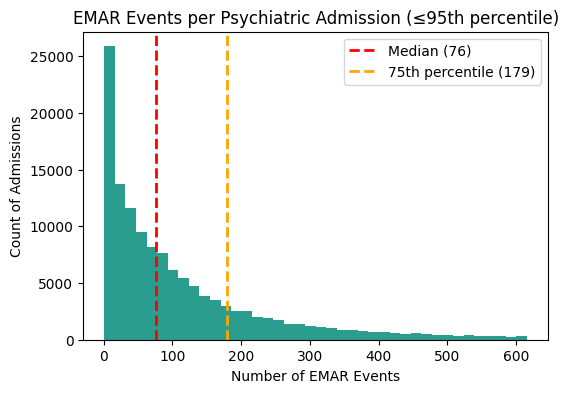

In [29]:
import numpy as np
import matplotlib.pyplot as plt

values = psy_emar_counts["emar_count"]

p95 = np.percentile(values, 95)
median = np.median(values)
q75 = np.percentile(values, 75)

plt.figure(figsize=(6,4))
plt.hist(values[values <= p95], bins=40, color="#2a9d8f")

plt.axvline(median, color="red", linestyle="--", linewidth=2, label=f"Median ({int(median)})")
plt.axvline(q75, color="orange", linestyle="--", linewidth=2, label=f"75th percentile ({int(q75)})")

plt.title("EMAR Events per Psychiatric Admission (≤95th percentile)")
plt.xlabel("Number of EMAR Events")
plt.ylabel("Count of Admissions")
plt.legend()

plt.show()

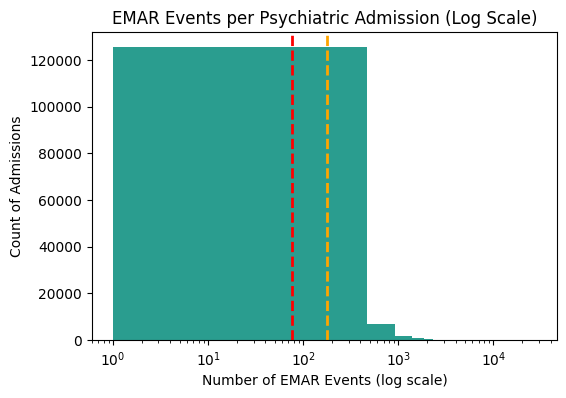

In [30]:
plt.figure(figsize=(6,4))
plt.hist(values, bins=60, color="#2a9d8f")

plt.xscale("log")

plt.axvline(median, color="red", linestyle="--", linewidth=2)
plt.axvline(q75, color="orange", linestyle="--", linewidth=2)

plt.title("EMAR Events per Psychiatric Admission (Log Scale)")
plt.xlabel("Number of EMAR Events (log scale)")
plt.ylabel("Count of Admissions")

plt.show()

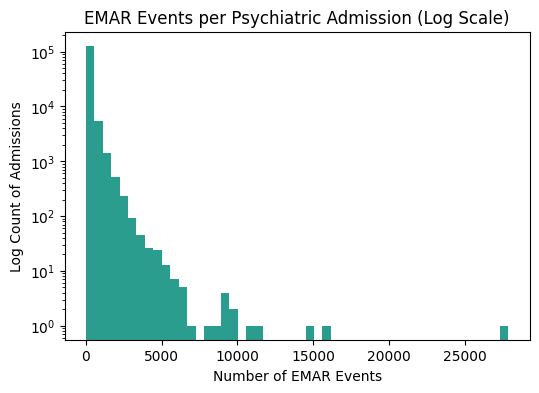

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(psy_emar_counts, bins=50, color="#2a9d8f")
plt.yscale("log")
plt.title("EMAR Events per Psychiatric Admission (Log Scale)")
plt.xlabel("Number of EMAR Events")
plt.ylabel("Log Count of Admissions")
plt.show()

### Medication Execution Density (EMAR)

Psychiatric admissions exhibit high execution activity:

- Median EMAR events per admission: 76
- 75th percentile: 179
- Mean: ~166
- Maximum: 27,890

Medication administration activity is substantially denser than prescription intent, reflecting repeated execution events per order.

The distribution is heavily right-skewed, with a pronounced extreme tail indicating a subset of admissions with very high execution intensity.

In [32]:
psy_with_rx.columns


Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'psych_dx_count',
       'psych_multi_flag', 'total_dx_count', 'is_repeat',
       'high_total_complexity', 'high_and_multi', 'rx_count', 'emar_count',
       'execution_ratio'],
      dtype='str')

In [33]:
psy_with_rx[["rx_count", "emar_count"]].head()

,rx_count,emar_count
0,14.0,18
1,15.0,23
2,28.0,50
3,24.0,47
4,NaN,0


In [34]:
psy_with_rx[["rx_count", "emar_count"]].corr()


,rx_count,emar_count
rx_count,1.000000,0.714431
emar_count,0.714431,1.000000


In [35]:
corr_pearson = psy_with_rx[["rx_count", "emar_count"]].corr(method="pearson")
corr_spearman = psy_with_rx[["rx_count", "emar_count"]].corr(method="spearman")
corr_kendall = psy_with_rx[["rx_count", "emar_count"]].corr(method="kendall")

corr_pearson, corr_spearman, corr_kendall


(            rx_count  emar_count
 rx_count    1.000000    0.714431
 emar_count  0.714431    1.000000,
             rx_count  emar_count
 rx_count    1.000000    0.398653
 emar_count  0.398653    1.000000,
             rx_count  emar_count
 rx_count    1.000000    0.320445
 emar_count  0.320445    1.000000)

### Correlation Between Prescription and Execution Density

Pearson correlation between prescription count and EMAR count is approximately 0.72, indicating strong linear association.

However, rank-based correlations are lower:
- Spearman: ~0.43
- Kendall: ~0.35

This divergence reflects the heavy-tailed distribution of EMAR counts. While execution intensity generally increases with prescription volume, the relationship is not strictly proportional across the distribution.

Execution density demonstrates additional variability beyond prescription intent, suggesting workflow-level dispersion within high-intensity admissions.


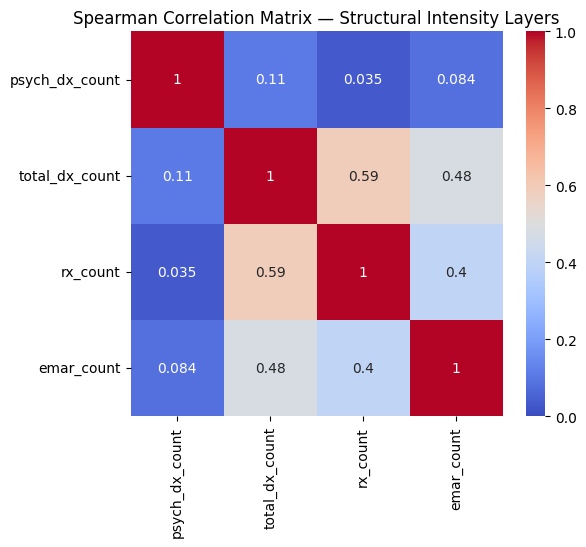

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = psy_with_rx[
    ["psych_dx_count", "total_dx_count", "rx_count", "emar_count"]
].corr(method="spearman")

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1
)
plt.title("Spearman Correlation Matrix — Structural Intensity Layers")
plt.show()

In [37]:
psy_with_rx["execution_ratio"] = (
    psy_with_rx["emar_count"] / psy_with_rx["rx_count"]
)

# Avoid division by zero
psy_with_rx["execution_ratio"] = psy_with_rx["execution_ratio"].replace([float("inf")], 0)
psy_with_rx["execution_ratio"] = psy_with_rx["execution_ratio"].fillna(0)

psy_with_rx["execution_ratio"].describe()


count     238565.0
mean      1.538849
std        2.13098
min            0.0
25%            0.0
50%            0.0
75%       2.764706
max      65.927273
Name: execution_ratio, dtype: Float64

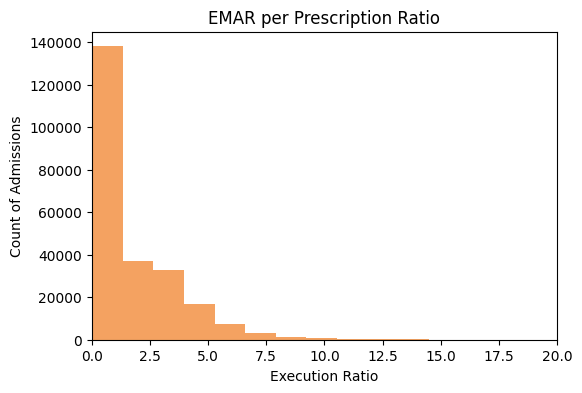

In [38]:
plt.figure(figsize=(6,4))
plt.hist(psy_with_rx["execution_ratio"], bins=50, color="#f4a261")
plt.xlim(0, 20)
plt.title("EMAR per Prescription Ratio")
plt.xlabel("Execution Ratio")
plt.ylabel("Count of Admissions")
plt.show()


### Execution Amplification Ratio (EMAR per Prescription)

- Median ratio: 0
- 75th percentile: ~2.76
- Mean: ~1.54
- Maximum: ~65.9

A large proportion of psychiatric admissions exhibit zero execution amplification, indicating no EMAR activity relative to prescriptions.

Among admissions with non-zero execution activity, medication administration typically scales at approximately 2–3 events per prescription.

A small subset demonstrates extreme execution amplification, suggesting concentrated workflow intensity within specific admissions.


In [39]:
active = psy_with_rx[psy_with_rx["rx_count"] > 0]

active["execution_ratio"].describe()

count     194013.0
mean      1.892222
std       2.217026
min            0.0
25%            0.0
50%       1.478261
75%       3.155556
max      65.927273
Name: execution_ratio, dtype: Float64

### Execution Amplification Among Prescription-Bearing Admissions

Restricting to admissions with at least one prescription:

- Median EMAR per prescription ratio: ~1.48
- 75th percentile: ~3.16
- Mean: ~1.89
- Maximum: ~65.9

Execution activity generally scales proportionally with prescription volume. Most admissions demonstrate approximately 1–3 administration events per order.

However, a small subset exhibits substantial execution amplification, indicating concentrated workflow intensity beyond proportional scaling.

In [40]:
active = psy_with_rx[psy_with_rx["rx_count"] > 0].copy()

In [41]:
active.groupby("high_total_complexity")["execution_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
high_total_complexity,,,,,,,,
False,132029.0,1.49706,1.983574,0.0,0.0,0.5,2.619048,45.5
True,61984.0,2.733936,2.441925,0.0,0.101087,2.620403,4.051282,65.927273


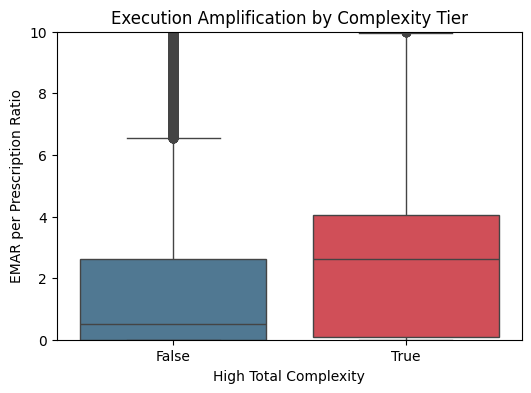

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=active,
    x="high_total_complexity",
    y="execution_ratio",
    hue="high_total_complexity",
    palette=["#457b9d", "#e63946"],
    legend=False
)

plt.ylim(0, 10)
plt.title("Execution Amplification by Complexity Tier")
plt.xlabel("High Total Complexity")
plt.ylabel("EMAR per Prescription Ratio")
plt.show()

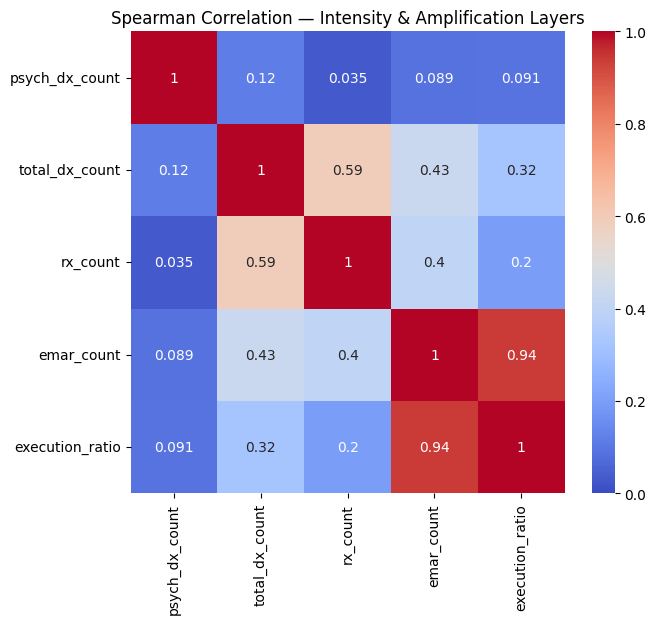

In [43]:
corr_matrix = active[
    ["psych_dx_count", "total_dx_count", "rx_count", "emar_count", "execution_ratio"]
].corr(method="spearman")

plt.figure(figsize=(7,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1
)
plt.title("Spearman Correlation — Intensity & Amplification Layers")
plt.show()


### Execution Amplification and Complexity

High diagnostic complexity is associated with:

- Higher prescription density
- Higher medication execution density
- Increased execution amplification per prescription

Median execution amplification increases from ~0.5 in lower-complexity admissions to ~2.6 in high-complexity admissions.

Spearman correlations indicate:
- Moderate association between total diagnoses and prescriptions (~0.59)
- Moderate association between prescriptions and EMAR events (~0.40)
- Positive association between diagnostic complexity and execution amplification (~0.32)

This suggests that operational intensity increases multiplicatively with diagnostic burden. High-complexity admissions not only generate more orders but also demonstrate increased administration activity per order.

In [44]:
from pathlib import Path
import pandas as pd

RAW = Path(r"D:\mimic-iv-3.1\Unzipped_raw_data")

icustays = pd.read_csv(
    RAW / "icustays.csv",
    usecols=["hadm_id"],
    dtype={"hadm_id": "Int64"}
)

In [45]:
icu_hadm_set = set(icustays["hadm_id"])

psy_with_rx["icu_flag"] = psy_with_rx["hadm_id"].isin(icu_hadm_set)

In [46]:
active = psy_with_rx[psy_with_rx["rx_count"] > 0]

active.groupby("icu_flag")["execution_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
icu_flag,,,,,,,,
False,153631.0,1.920926,2.285891,0.0,0.0,1.472727,3.206897,65.927273
True,40382.0,1.783016,1.928865,0.0,0.0,1.5,2.972833,30.38756


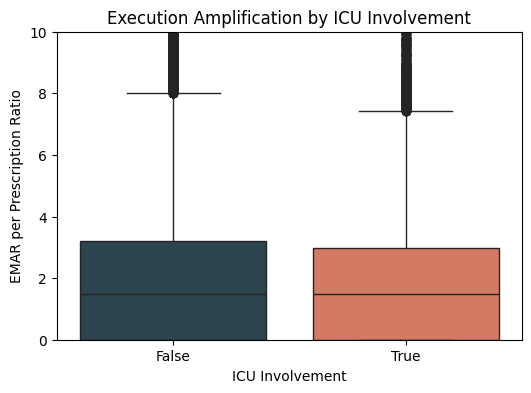

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=active,
    x="icu_flag",
    y="execution_ratio",
    hue="icu_flag",
    palette=["#264653", "#e76f51"],
    legend=False
)

plt.ylim(0, 10)
plt.title("Execution Amplification by ICU Involvement")
plt.xlabel("ICU Involvement")
plt.ylabel("EMAR per Prescription Ratio")
plt.show()

### Execution Amplification and ICU Involvement

Execution amplification (EMAR per prescription ratio) does not substantially differ between ICU and non-ICU psychiatric admissions.

Median ratios are nearly identical (~1.5), and distributional spread is comparable across groups.

Extreme amplification values are observed predominantly outside ICU admissions.

This suggests that medication execution amplification is more closely associated with diagnostic complexity than with ICU-level escalation.


In [48]:
active.groupby("is_repeat")["execution_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
is_repeat,,,,,,,,
False,37348.0,1.865474,2.084045,0.0,0.0,1.6,3.028587,45.5
True,156665.0,1.898598,2.247526,0.0,0.0,1.4375,3.1875,65.927273


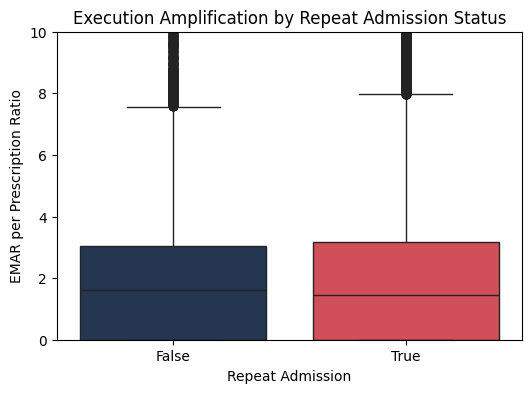

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=active,
    x="is_repeat",
    y="execution_ratio",
    hue="is_repeat",
    palette=["#1d3557", "#e63946"],
    legend=False
)

plt.ylim(0, 10)
plt.title("Execution Amplification by Repeat Admission Status")
plt.xlabel("Repeat Admission")
plt.ylabel("EMAR per Prescription Ratio")
plt.show()


### Execution Amplification and Repeat Admission Status

Execution amplification (EMAR per prescription ratio) shows minimal difference between repeat and non-repeat admissions.

Median and upper quartile values are nearly identical across groups, and distributional overlap is substantial.

This suggests that execution amplification is not strongly driven by longitudinal admission churn, but is more closely associated with diagnostic complexity.


In [50]:
active.groupby("psych_multi_flag")["execution_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
psych_multi_flag,,,,,,,,
False,108729.0,1.710821,2.051851,0.0,0.0,1.181818,2.947368,41.0
True,85284.0,2.12349,2.391397,0.0,0.0,1.787745,3.418605,65.927273


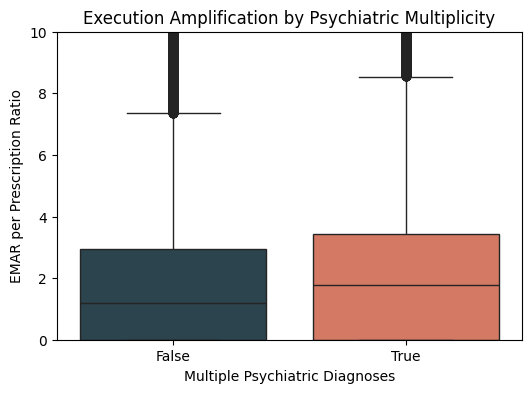

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=active,
    x="psych_multi_flag",
    y="execution_ratio",
    hue="psych_multi_flag",
    palette=["#264653", "#e76f51"],
    legend=False
)

plt.ylim(0, 10)
plt.title("Execution Amplification by Psychiatric Multiplicity")
plt.xlabel("Multiple Psychiatric Diagnoses")
plt.ylabel("EMAR per Prescription Ratio")
plt.show()

### Execution Amplification and Psychiatric Multiplicity

Admissions with multiple psychiatric diagnoses demonstrate higher execution amplification compared to those with a single psychiatric diagnosis.

Median EMAR per prescription ratio increases from approximately 1.18 (single diagnosis) to 1.79 (multiple diagnoses).

Distributional shifts indicate that psychiatric multiplicity contributes to increased medication administration intensity per prescription, independent of ICU involvement or repeat admission status.

This suggests that clustering of psychiatric diagnoses has a measurable operational impact on medication execution behavior.

In [52]:
psy_with_rx["admittime"] = pd.to_datetime(psy_with_rx["admittime"])
psy_with_rx["dischtime"] = pd.to_datetime(psy_with_rx["dischtime"])

psy_with_rx["los_days"] = (
    (psy_with_rx["dischtime"] - psy_with_rx["admittime"]).dt.total_seconds() / (60*60*24)
)

psy_with_rx["los_days"].describe()

count    238565.000000
mean          5.367630
std           8.264140
min          -0.943750
25%           1.136111
50%           3.011111
75%           6.220833
max         515.562500
Name: los_days, dtype: float64

In [53]:
psy_with_rx[psy_with_rx["los_days"] < 0][
    ["hadm_id", "admittime", "dischtime", "los_days"]
].head()

,hadm_id,admittime,dischtime,los_days
908,26463092,2165-08-13 14:00:00,2165-08-13 00:00:00,-0.583333
3201,29334858,2163-03-01 20:43:00,2163-03-01 02:32:00,-0.757639
11437,21379384,2131-05-28 22:22:00,2131-05-28 17:25:00,-0.206250
12086,28680274,2182-01-03 02:44:00,2182-01-03 00:00:00,-0.113889
12748,28309753,2120-04-06 03:15:00,2120-04-06 02:53:00,-0.015278


In [54]:
psy_with_rx["los_days"] = psy_with_rx["los_days"].clip(lower=0)

In [55]:
psy_with_rx["los_days"].describe()

count    238565.000000
mean          5.367710
std           8.264085
min           0.000000
25%           1.136111
50%           3.011111
75%           6.220833
max         515.562500
Name: los_days, dtype: float64

In [56]:
active = psy_with_rx[psy_with_rx["rx_count"] > 0].copy()

active[["los_days", "execution_ratio"]].corr(method="spearman")

,los_days,execution_ratio
los_days,1.000000,0.334095
execution_ratio,0.334095,1.000000


### Length of Stay and Execution Amplification

Spearman correlation between length of stay (LOS) and execution amplification is approximately 0.33.

Longer admissions are moderately associated with higher EMAR per prescription ratios, indicating that time exposure contributes to execution intensity.

However, the correlation is not dominant, suggesting that amplification is not solely driven by duration but also reflects underlying diagnostic complexity.

In [57]:
active["los_bin"] = pd.cut(
    active["los_days"],
    bins=[0, 2, 5, 10, 30, 600],
    labels=["0–2d", "2–5d", "5–10d", "10–30d", "30+d"]
)

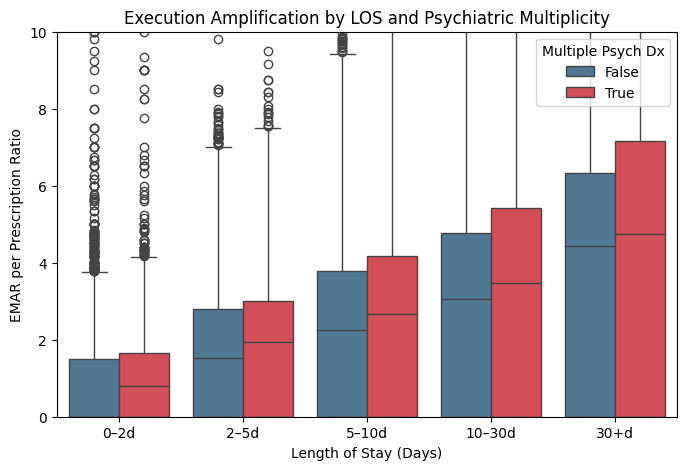

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.boxplot(
    data=active,
    x="los_bin",
    y="execution_ratio",
    hue="psych_multi_flag",
    palette=["#457b9d", "#e63946"]
)

plt.ylim(0, 10)
plt.title("Execution Amplification by LOS and Psychiatric Multiplicity")
plt.xlabel("Length of Stay (Days)")
plt.ylabel("EMAR per Prescription Ratio")
plt.legend(title="Multiple Psych Dx")
plt.show()

### Execution Amplification Across LOS and Psychiatric Multiplicity

Execution amplification increases progressively with length of stay, indicating duration-dependent scaling of medication administration intensity.

Within each LOS stratum, admissions with multiple psychiatric diagnoses consistently demonstrate higher amplification compared to single-diagnosis admissions.

The persistence of this upward shift across duration bands suggests that psychiatric multiplicity contributes to execution intensity beyond time exposure alone.

Amplification therefore appears complexity-embedded and duration-weighted rather than escalation-driven.


In [59]:
transfers = pd.read_csv(
    RAW / "transfers.csv",
    usecols=["hadm_id", "transfer_id"],
    dtype={"hadm_id": "Int64"}
)

In [60]:
if "transfer_count" in psy_with_rx.columns:
    psy_with_rx = psy_with_rx.drop(columns=["transfer_count"])

In [61]:
transfer_counts = transfers["hadm_id"].value_counts()

psy_with_rx = psy_with_rx.merge(
    transfer_counts.rename("transfer_count").reset_index(),
    on="hadm_id",
    how="left"
)

psy_with_rx["transfer_count"] = psy_with_rx["transfer_count"].fillna(0)

In [62]:
psy_with_rx["transfer_count"].describe()

count    238565.0
mean     3.745604
std      1.535874
min           0.0
25%           3.0
50%           3.0
75%           4.0
max          34.0
Name: transfer_count, dtype: Float64

In [63]:
psy_with_rx.groupby("psych_multi_flag")["transfer_count"].describe()

,count,mean,std,min,25%,50%,75%,max
psych_multi_flag,,,,,,,,
False,132179.0,3.727218,1.50596,0.0,3.0,3.0,4.0,34.0
True,106386.0,3.768447,1.571955,0.0,3.0,3.0,4.0,29.0


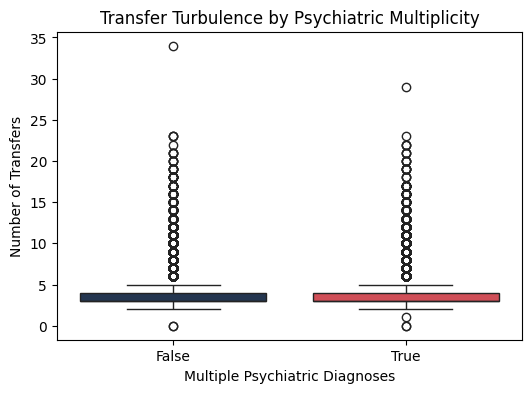

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=psy_with_rx,
    x="psych_multi_flag",
    y="transfer_count",
    hue="psych_multi_flag",
    palette=["#1d3557", "#e63946"],
    legend=False
)

plt.title("Transfer Turbulence by Psychiatric Multiplicity")
plt.xlabel("Multiple Psychiatric Diagnoses")
plt.ylabel("Number of Transfers")
plt.show()


### Transfer Turbulence and Psychiatric Multiplicity

Transfer counts per admission show minimal difference between single and multiple psychiatric diagnosis groups.

Median transfer count remains 3 across both groups, with nearly identical distributional spread.

This indicates that psychiatric multiplicity does not substantially increase movement instability within hospital care states.

While psychiatric clustering amplifies medication execution intensity, it does not appear to increase physical transfer turbulence.

In [65]:
psy_with_rx.groupby("high_total_complexity")["transfer_count"].describe()

,count,mean,std,min,25%,50%,75%,max
high_total_complexity,,,,,,,,
False,175919.0,3.481392,1.20911,0.0,3.0,3.0,4.0,22.0
True,62646.0,4.487549,2.032546,0.0,3.0,4.0,5.0,34.0


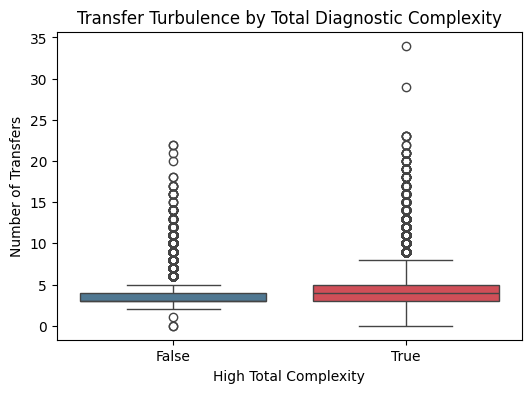

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.boxplot(
    data=psy_with_rx,
    x="high_total_complexity",
    y="transfer_count",
    hue="high_total_complexity",
    palette=["#457b9d", "#e63946"],
    legend=False
)

plt.title("Transfer Turbulence by Total Diagnostic Complexity")
plt.xlabel("High Total Complexity")
plt.ylabel("Number of Transfers")
plt.show()


### Transfer Turbulence and Total Diagnostic Complexity

High total diagnostic complexity is associated with increased transfer turbulence.

Median transfer count increases from 3 in lower-complexity admissions to 4 in high-complexity admissions, with broader distributional spread.

This suggests that global multimorbidity contributes to increased movement instability within hospital care states.

Unlike psychiatric multiplicity, which primarily influences medication execution intensity, total diagnostic burden affects both operational intensity and physical transfer turbulence.

In [67]:
active = psy_with_rx[psy_with_rx["rx_count"] > 0].copy()

active[["transfer_count", "execution_ratio"]].corr(method="spearman")

,transfer_count,execution_ratio
transfer_count,1.000000,0.139655
execution_ratio,0.139655,1.000000


## Notebook 02 — Structural Instability Map

Two distinct instability dimensions were identified:

1. Execution Intensity (EMAR amplification per prescription)
2. Movement Turbulence (transfer count per admission)

Key findings:

- Total diagnostic complexity increases both execution intensity and transfer turbulence.
- Psychiatric multiplicity increases execution amplification but does not increase transfer turbulence.
- Length of stay moderately increases execution amplification.
- ICU involvement and repeat admission status do not materially alter execution amplification.
- Execution amplification and transfer turbulence are weakly correlated (Spearman ≈ 0.14), indicating largely independent instability axes.

Overall, instability within psychiatric admissions appears layered rather than unified, with diagnostic burden influencing operational intensity and movement dynamics through partially independent pathways.

In [68]:
schema_02 = pd.DataFrame({
    "column": psy_with_rx.columns,
    "dtype": psy_with_rx.dtypes.astype(str),
    "non_null_count": psy_with_rx.notnull().sum().values
})

schema_02.to_csv("psy_admissions_02_schema_contract.csv", index=False)

schema_02

,column,dtype,non_null_count
subject_id,subject_id,Int64,238565
hadm_id,hadm_id,Int64,238565
admittime,admittime,datetime64[us],238565
dischtime,dischtime,datetime64[us],238565
deathtime,deathtime,string,5228
admission_type,admission_type,string,238565
admit_provider_id,admit_provider_id,string,238563
admission_location,admission_location,string,238565
discharge_location,discharge_location,string,168797
insurance,insurance,string,232837


In [72]:
psy_with_rx.to_csv(
    "psy_admissions_instability_layer_v1.csv",
    index=False
)

In [73]:
psy_with_rx.columns.tolist()

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'psych_dx_count',
 'psych_multi_flag',
 'total_dx_count',
 'is_repeat',
 'high_total_complexity',
 'high_and_multi',
 'rx_count',
 'emar_count',
 'execution_ratio',
 'icu_flag',
 'los_days',
 'transfer_count']

In [74]:
meta_02 = pd.DataFrame({
    "column": psy_with_rx.columns,
    "dtype": psy_with_rx.dtypes.astype(str),
    "layer": [
        "identity",          # subject_id
        "identity",          # hadm_id
        "temporal",          # admittime
        "temporal",          # dischtime
        "temporal",          # deathtime
        "categorical",       # admission_type
        "categorical",       # admit_provider_id
        "categorical",       # admission_location
        "categorical",       # discharge_location
        "categorical",       # insurance
        "categorical",       # language
        "categorical",       # marital_status
        "categorical",       # race
        "temporal",          # edregtime
        "temporal",          # edouttime
        "outcome",           # hospital_expire_flag
        "psy_structure",     # psych_dx_count
        "psy_structure",     # psych_multi_flag
        "global_complexity", # total_dx_count
        "utilization",       # is_repeat
        "global_complexity", # high_total_complexity
        "global_complexity", # high_and_multi
        "med_intent",        # rx_count
        "med_execution",     # emar_count
        "med_execution",     # execution_ratio
        "utilization",       # icu_flag
        "temporal",          # los_days
        "utilization"        # transfer_count
    ]
})

meta_02.to_csv(
    "psy_instability_metadata_layer_02_v1.csv",
    index=False
)

meta_02


,column,dtype,layer
subject_id,subject_id,Int64,identity
hadm_id,hadm_id,Int64,identity
admittime,admittime,datetime64[us],temporal
dischtime,dischtime,datetime64[us],temporal
deathtime,deathtime,string,temporal
admission_type,admission_type,string,categorical
admit_provider_id,admit_provider_id,string,categorical
admission_location,admission_location,string,categorical
discharge_location,discharge_location,string,categorical
insurance,insurance,string,categorical
